# Project 2: Classification
**Dusty Shaw**

## Data Loading and Cleaning

In [2]:
# I have a Data folder in the root of my project
import pandas as pd

#// C:\Users\shust\code\_spring2025\project-2-classification\Data\drug200.csv
data = pd.read_csv("./Data/drug200.csv")

data['Drug'].unique()  # drug types: ['DrugY', 'drugC', 'drugX', 'drugA', 'drugB']



data.isna().sum()  # no na variables

data.describe() # 200 rows, two continuous vars (Age, Na_to_K)
                # discrete vars: (Sex, BP, Cholesterol, Drug)

data['BP'].unique() # BP types: ['HIGH', 'LOW', 'NORMAL']
data['Sex'].unique() # Sex types: ['M', 'F']

data.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


## Encoding categorical vars

In [3]:
# mapping low:0, normal: 1, high: 2
data['BP'].unique() # BP types: ['HIGH', 'LOW', 'NORMAL']


bp_mapping = {'HIGH': 2, 'NORMAL': 1, 'LOW': 0}

data['BP'] = data['BP'].map(bp_mapping)


In [4]:
data['Cholesterol'].unique() # Chol types: ['HIGH', 'NORMAL']

chol_mapping = {'HIGH': 1, 'NORMAL': 0}

data['Cholesterol'] = data['Cholesterol'].map(chol_mapping)

In [5]:
data['Sex'].unique() # Sex types: ['M', 'F']

sex_mapping = {'M': 0, 'F': 1}

data['Sex'] = data['Sex'].map(sex_mapping)

In [6]:
data.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,1,2,1,25.355,DrugY
1,47,0,0,1,13.093,drugC
2,47,0,0,1,10.114,drugC
3,28,1,1,1,7.798,drugX
4,61,1,0,1,18.043,DrugY


## EDA

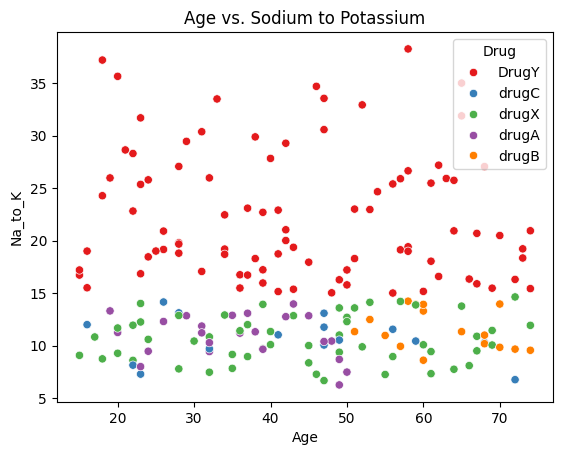

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(x=data['Age'], y=data['Na_to_K'], hue=data['Drug'], palette='Set1')

plt.title('Age vs. Sodium to Potassium')
plt.show()

There doesn't really seem to be any correlation between age and the sodium_potassium column. We can also see that there are some pretty non-distinct areas where the drug types are. We could possibly create a separation from DrugY types and non-DrugY types that cuts off around 14 Na_to_K. However, non-drug types seems to be fairly scattered and mixed below the horizontal 14th line. 

We might also be able to create a separation, like in an SVC vertically after Age 50, separating drugA types and drugB types.

However, there are other variables that might effect the drug types, which is hard to visualize in a 2d plane.

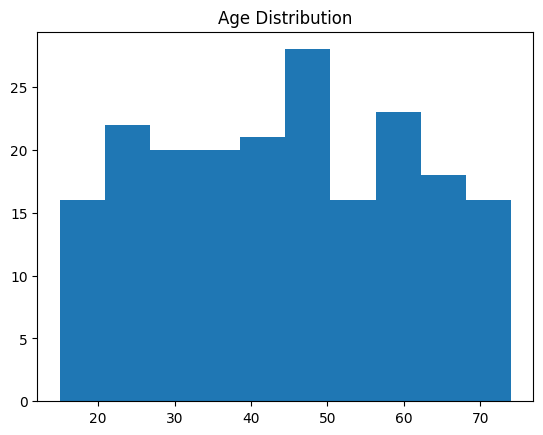

In [8]:
plt.hist(x=data['Age'])
plt.title('Age Distribution')
plt.show()

It seems like there was a good variety of ages in this test group, and there is a fairly even distribution of ages.

Text(0.5, 1.0, 'Distribution of Drug Types')

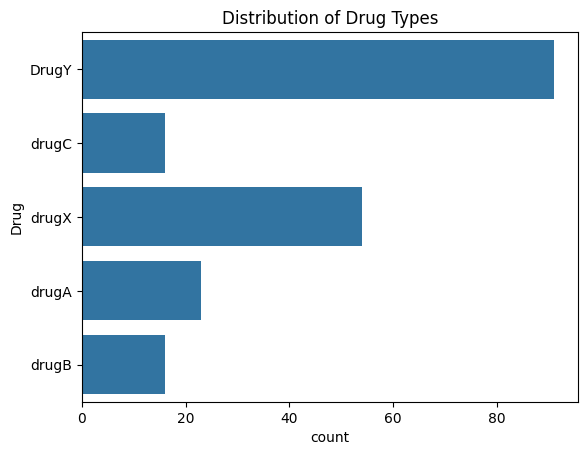

In [9]:
sns.countplot(data['Drug'])
plt.title("Distribution of Drug Types")


There are more DrugY than any other drug by far, with drugX coming in second place. This might effect our model. 

Text(0.5, 1.0, 'Age vs Gender')

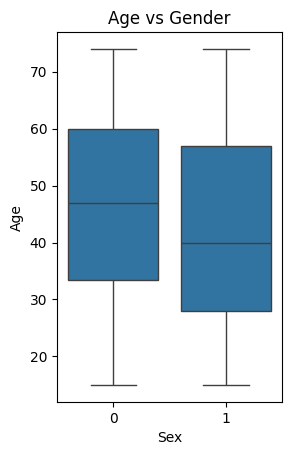

In [10]:
plt.subplot(1, 2, 1)
sns.boxplot(x=data['Sex'], y=data['Age']) # M = 0, F = 1
plt.title('Age vs Gender')

Male entries are slightly older than females in this study, but the age range and averages are fairly close.

## Cross Validation

In [11]:
# I do the cross validation within the models.

# Models

## 1. k-Nearest Neighbors

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score

X = data.drop(columns=['Drug']) 
y = data['Drug'] 

# -- make the 'Drug' column not strings
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=32) # -- Cross validation

scaler = StandardScaler()   # -- Scale variables before modeling
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -- use KNN model
# k = sqrt(200) = 14.1 ~> 17
k = 17
kNN = KNeighborsClassifier(n_neighbors=k, p=3, metric='euclidean')

kNN.fit(X_train_scaled, y_train)
y_pred = kNN.predict(X_test_scaled)

# -- describe metrics
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.60      0.86      0.71        28
           1       1.00      0.25      0.40         8
           2       0.67      0.40      0.50         5
           3       0.33      0.33      0.33         3
           4       0.58      0.44      0.50        16

    accuracy                           0.60        60
   macro avg       0.64      0.46      0.49        60
weighted avg       0.64      0.60      0.57        60

[[24  0  1  0  3]
 [ 6  2  0  0  0]
 [ 2  0  2  0  1]
 [ 1  0  0  1  1]
 [ 7  0  0  2  7]]


This one did fairly well. However, if you fail to properly scale the variables before running the model. However, it only gets an accuracy of 60%, and there are a lot of misclassifications in the confusion matrix. 

I chose 17 as k because we have around 200 rows. This leads to about 14 after taking the square root. I then chose 17, because it was a prime number close to that which was not divisible by the number of drug types we had (5).

However, adjusting k to be 19 increases accuracy by 65%. This means that giving the radius of the kNN neighbors algorithm more neighbor data points to analyze might increase the accuracy.  

Any higher of a number might cause underfitting of the kNN algorithm. This means that we are being too lax with our classification 'radius' and are simplifying it too much. So I would probably choose 17 or 19 for this model.


## 2. SVC

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC 

X = data.drop(columns=['Drug'])
y = data['Drug']

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=32)

svc_model = Pipeline([
    ('scaler', StandardScaler()), 
    ('classifier', LinearSVC(C=10, loss='hinge'))
])


svc_model.fit(X_train, y_train)
y_pred = svc_model.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.96      0.92        28
           1       0.89      1.00      0.94         8
           2       0.83      1.00      0.91         5
           3       1.00      1.00      1.00         3
           4       1.00      0.69      0.81        16

    accuracy                           0.90        60
   macro avg       0.92      0.93      0.92        60
weighted avg       0.91      0.90      0.90        60

[[27  0  1  0  0]
 [ 0  8  0  0  0]
 [ 0  0  5  0  0]
 [ 0  0  0  3  0]
 [ 4  1  0  0 11]]


C:\Users\shust\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


With this SVC model, you can enter in various values for c, the regularization parameter. A high c means you might get fewer misclassifications and have an overall smaller margin. 

Choosing a low c will give the model greater margins, which might too much of a simplification, and could give us less accuracy.  

When modeling this, I chose various numbers for c, starting with 1, and going to 10, then 100.

There was a great increase in accuracy from 1 to 10, but going from 10 to 100 had little effect. When c is too high, we then start to overfit on our training data, and tend to perform poorly when we actually use the testing set. You can see this when entering numbers like 1000 or 10000, dropping our accuracy to the mid 80% range.



## 3. Random Forests

In [14]:
from sklearn.ensemble import RandomForestClassifier

scaler = StandardScaler()   # -- Scale variables before modeling
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

numberOfTreesInForest = 100
clf = RandomForestClassifier(n_estimators=numberOfTreesInForest)
clf.fit(X_train_scaled, y_train)

y_pred = clf.predict(X_test_scaled)

from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98        28
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         3
           4       1.00      0.94      0.97        16

    accuracy                           0.98        60
   macro avg       0.99      0.99      0.99        60
weighted avg       0.98      0.98      0.98        60

[[28  0  0  0  0]
 [ 0  8  0  0  0]
 [ 0  0  5  0  0]
 [ 0  0  0  3  0]
 [ 1  0  0  0 15]]


Overall, the RandomForest classifier did a pretty good job at getting the drug types correct with an accuracy of 98%! This could be because we gave it 100 forests, meaning it had 100 decision trees made and increases the accuracy each time. 

However, just like with the SVCs, increasing the number of forests by a power of ten has diminishing returns in terms of accuracy. It doesn't really get much better, but stagnates at around 98%.

Interestingly, choosing just 10 random forests can cause your model to spit out something different every time. This is because it isn't given enough small steps or iterations (like in a gradient descent) to refine each branch of the tree. So, we don't want to choose too low of a number of trees. 

I found that 100 trees seemed to work best, and produced the same result every time. This way, we aren't wasting computing power creating a thousand trees, but we still get the predictability and reliability of the model. 

Recall was great, being exactly 1.00. This might be a rounding error, but this means that the model got every true positive entry correct. 

# When you complete the models, write a brief summary of the performance for each model. Some questions you may want to consider:

**Which model performed the best?**

Random forest seems to perform best in terms of accuracy, precision, recal, and F1-score.

**Which model took the most time to run? Which took the least time to run?**  

Random forest also took the longest to run, especially when trying to create 1000 trees or even 10000+ trees. This is one of the downsides of runing random forests, is that they might take a long time to create all of those decision trees.

**Which model was the easiest to code? Which model was the most challenging to code?**    

I think they were all about the same to code, but for me, the kNN was the most difficult to visualize what was really going on. kNN is easy to understand in one dimension, but when you start to add dimensions, it is really difficult for me to picture what the model is doing to get the answers it does. 

I would want to consider the transparency of each model, meaning understanding what each step of the model is taking. In Nural networks for example, we don't really understand or can hand-model each step in between the input and output layer. Not understanding that means you might have a more difficult time changing and tweaking aspects of the model to increase performance metrics.
